In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import time

## Dataset

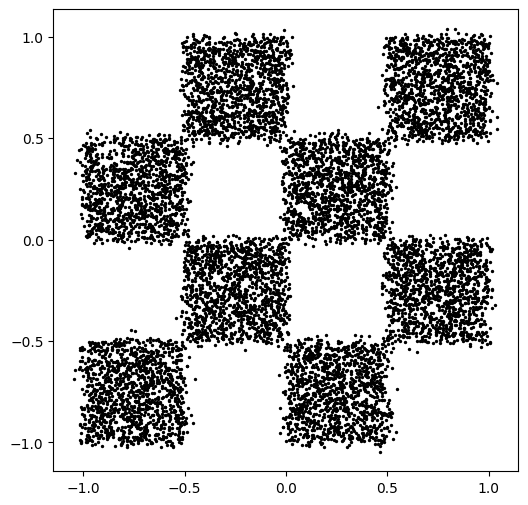

In [ ]:
def generate_dataset(num_samples=10000, num_cells=4, noise_std=0.05):
    samples = []

    while len(samples) < num_samples:
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)

        cell_x = int((x + 1) / 2 * num_cells)
        cell_y = int((y + 1) / 2 * num_cells)

        if (cell_x + cell_y) % 2 == 0:
            noisy_point = [x + np.random.normal(0, noise_std),
                           y + np.random.normal(0, noise_std)]
            samples.append(noisy_point)

    return np.array(samples)

import matplotlib.pyplot as plt

dataset = generate_dataset(num_samples=10000, num_cells=4, noise_std=0.02)

plt.figure(figsize=(6, 6))
plt.axis("equal")
plt.scatter(dataset[:, 0], dataset[:, 1], s=2, color='black')
plt.show()


## Model

In [ ]:
def sinusoidal_time_embedding(t, time_emb_dim):
    device = t.device
    half_dim = time_emb_dim // 2
    step = math.log(10000) / (half_dim - 1)
    frequency = torch.exp(-step * torch.arange(half_dim, device=device))
    t = t[:, None]
    frequency = frequency[None, :]
    emb = t * frequency
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb

class TimeMLP(nn.Module):
    def __init__(self, time_emb_dim=128, time_out_dim=512):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, 128),
            nn.ReLU(),
            nn.Linear(128, time_out_dim)
        )

    def forward(self, t):  # t: [B]
        t = t.float()
        t_emb = sinusoidal_time_embedding(t, self.time_emb_dim)
        return self.time_mlp(t_emb)

In [ ]:
class FlowMatchingNet(nn.Module):
    def __init__(self, x_dim=2, time_emb_dim=128, time_out_dim=128, hidden_dim=256):
        super().__init__()
        self.time_mlp = TimeMLP(time_emb_dim, time_out_dim)

        self.net = nn.Sequential(
            nn.Linear(x_dim + time_out_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, x_dim)
        )

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        xt = torch.cat([x, t_emb], dim=1)
        return self.net(xt)

In [ ]:
model = FlowMatchingNet(x_dim=2, time_emb_dim=128, time_out_dim=128, hidden_dim=512)
optim = torch.optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
!pip install torchinfo
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
FlowMatchingNet                          --
├─TimeMLP: 1-1                           --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  16,512
│    │    └─ReLU: 3-2                    --
│    │    └─Linear: 3-3                  16,512
├─Sequential: 1-2                        --
│    └─Linear: 2-2                       67,072
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       262,656
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       262,656
│    └─ReLU: 2-7                         --
│    └─Linear: 2-8                       262,656
│    └─ReLU: 2-9                         --
│    └─Linear: 2-10                      262,656
│    └─ReLU: 2-11                        --
│    └─Linear: 2-12                      1,026
Total params: 1,151,746
Trainable params: 1,151,746
Non-trainable params: 0

In [ ]:
data = torch.Tensor(dataset)
training_steps = 20_000
batch_size = 64
losses = []

print_every = 2000
start_time = time.time()

for i in range(training_steps):
    x1 = data[torch.randint(data.size(0), (batch_size,))]
    x0 = torch.randn_like(x1)
    t = torch.rand(batch_size)

    xt = (1 - t[:, None]) * x0 + t[:, None] * x1
    target = x1 - x0

    pred = model(xt, t)
    loss = ((target - pred) ** 2).mean()

    loss.backward()
    optim.step()
    optim.zero_grad()

    losses.append(loss.item())

    if (i + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '.format(
            i + 1, elapsed * 1000 / print_every, loss.item()))
        start_time = time.time()

| iter   2000 | 35.97 ms/step | loss    0.723 
| iter   4000 | 37.25 ms/step | loss    0.874 
| iter   6000 | 37.76 ms/step | loss    0.869 
| iter   8000 | 37.28 ms/step | loss    0.869 
| iter  10000 | 37.54 ms/step | loss    0.958 
| iter  12000 | 36.97 ms/step | loss    0.740 
| iter  14000 | 37.27 ms/step | loss    0.731 
| iter  16000 | 37.10 ms/step | loss    1.073 
| iter  18000 | 37.66 ms/step | loss    0.804 
| iter  20000 | 37.45 ms/step | loss    0.714 


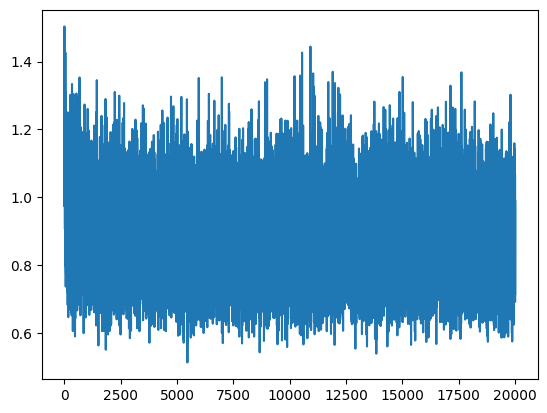

In [ ]:
plt.plot(losses)

## Visualize path

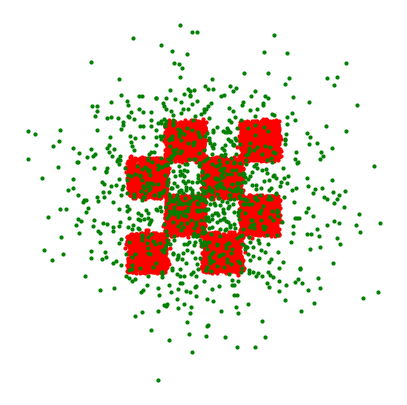

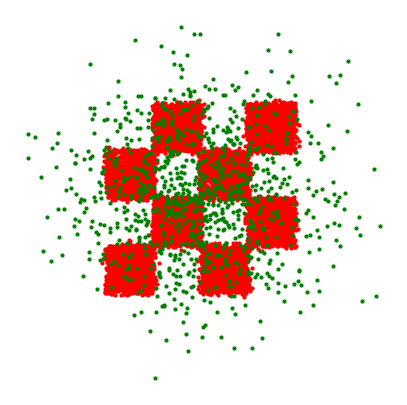

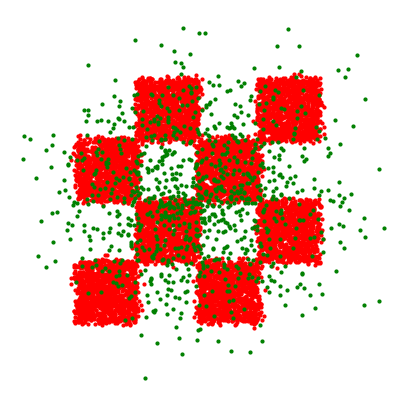

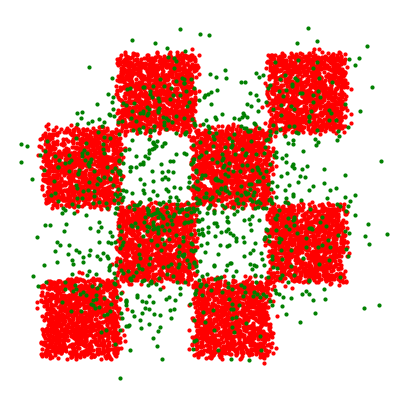

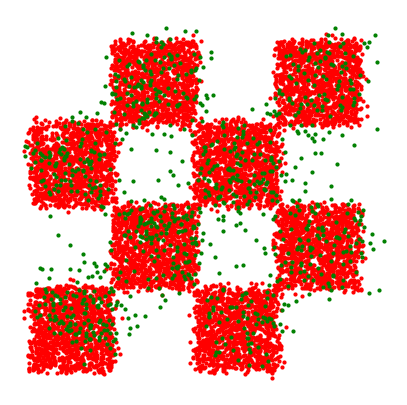

In [ ]:
torch.manual_seed(20)

model.eval().requires_grad_(False)

xt = torch.randn(1000, 2)
steps = 2000
plot_every = 400

for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
    t_batch = t.expand(xt.size(0))
    pred = model(xt, t_batch)
    xt = xt + (1 / steps) * pred

    if i % plot_every == 0:
        plt.figure(figsize=(5, 5))
        plt.axis("equal")
        plt.axis("off")
        plt.scatter(dataset[:, 0], dataset[:, 1], color="red", s=4)
        plt.scatter(xt[:, 0], xt[:, 1], color="green", s=4)
        plt.show()